## 기초 모듈

In [1]:
# Basics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# NLP
import nltk
from soynlp.normalizer import *
from hanspell import spell_checker
from konlpy.tag import Okt

# ML
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score

## 데이터 전처리

In [2]:
# 파일 불러오기

review_df = pd.read_csv('./MK_review_proceed_data.csv', encoding='utf-8', index_col=0) # df_review는 전체년도 리뷰 크롤링 파일


In [3]:
## 말뭉치 만들기##### 말뭉치 만들기

import ast

nouns_list = []

for tokens in review_df['tokenized_removed_review']:
    
    nouns_list.extend(ast.literal_eval(tokens))
    
nouns_list_set = list(set(nouns_list))
print('토큰화 말뭉치 개수 :',len(nouns_list))
print('중복을 제거한 말뭉치 개수 :',len(nouns_list_set))

토큰화 말뭉치 개수 : 122378
중복을 제거한 말뭉치 개수 : 12527


## 파이프라인 sklearn vs imblearn
- sklearn에서는 샘플링 작업을 할수 없다한다.
- 샘플링 작업은 imblearn 모듈을 설치하고 작업을 해야한다.
- 만약 파이프라인에 샘플링을 추가하고 싶다면 imblearn의 파이프라인으로 만들어야함.
- 그럼 sklearn 과 imblearn에서 차이가 있을 수 도 있으니 이또한 비교를 해봐야...하나??

다행히 pipeline과 make_pipeline 이라는 두개의 객체로 쉽게 한번에 구현 할 수 있겠따!!
- 둘다 똑같은 방법과 같은 객체라 같은 값을  반환 하지만 유일한 차이점은 각 파라미터 이름을 사용자가 정의할수 있냐 없냐 차이다.
```
Pipeline(['sampling' : SMOTE()]) ---> {'sampling__k_neighbors' : [1,2,3]}
make_pipeline(SMOTE()) ---> {'smote__k_neighbors' : [1,2,3]}
```

그렇지만 sklearn과 imblearn이 다를 수도 있지 않을까...? 

로지스틱 모델로 두 파이프 라인을 비교해보자

## sklearn 파이프라인 학습

Fitting 5 folds for each of 3 candidates, totalling 15 fits
finish


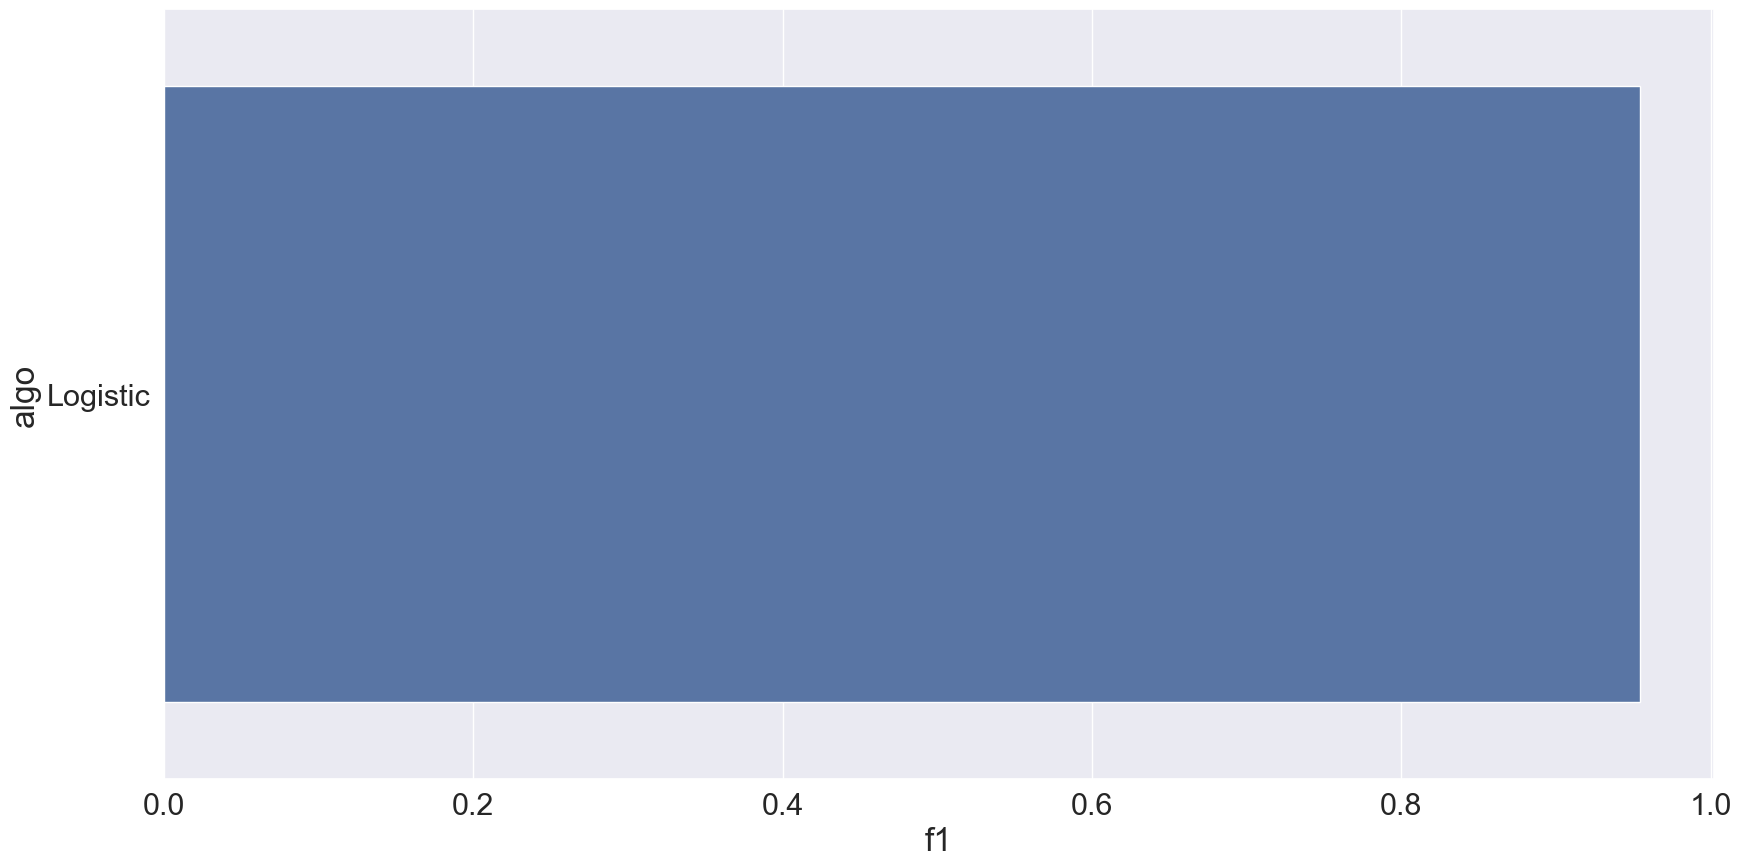

In [30]:
##### model
import lightgbm as lgbm
from sklearn.linear_model import LogisticRegression


##### sampling
from imblearn.over_sampling import SMOTE

##### pipeline
from sklearn.pipeline import Pipeline


##### dataset
X = review_df['reviews_for_vectorize']; y = review_df['label']


##### split train and test data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13, stratify=y)


##### cross-validation
skfold = StratifiedKFold(n_splits=5)


##### pipeline model
pipe_Logistic = Pipeline([
                ('vec', TfidfVectorizer(decode_error='ignore')),
                ('fit', LogisticRegression(solver='saga'))])


##### pipeline params -- vectorizer, smote
ks = [1,5,10]

grid_params_Logistic = [{
    "vec__min_df" : ks,
    "fit__C": [5],
    "fit__solver" : ["saga"],
    "fit__penalty" : ["l2"],
    "fit__max_iter": [1000]
}]

pipe = [pipe_Logistic]
params = [grid_params_Logistic]

jobs = 20

grid_dict = {
    0: 'Logistic',
            }

sklearn_model_object = {}; sklearn_model_acc = {}; sklearn_model_roc_auc = {}; sklearn_model_f1 = {}; sklearn_model_best_params = {}

#1. scoring = 'neg_mean_absolute_error' 로 설정.
# 일반적으로 scoring을 값이 클 수록 모델 성능이 좋은 것으로 사이킷런에서 인식하는데, 
# mae는 값이 클 수록 모델 성능이 저하되는 것이므로 Negative 키워드를 붙여서 사용

for idx , (param , model) in enumerate(zip(params , pipe)) :
    search = GridSearchCV(model, param, scoring  = "f1", cv=skfold,
                           n_jobs=jobs , verbose=True ) #  verbose가 있으면 함수 수행시 발생하는 상세한 정보 출력
    search.fit(X_train , y_train)
    y_pred = search.predict(X_test)
       
    sklearn_model_object[grid_dict.get(idx)] = search
    sklearn_model_acc[grid_dict.get(idx)] = accuracy_score(y_test, y_pred)  
    sklearn_model_roc_auc[grid_dict.get(idx)] = roc_auc_score(y_test, y_pred)
    sklearn_model_f1[grid_dict.get(idx)] = f1_score(y_test, y_pred)

    sklearn_model_best_params[grid_dict.get(idx)] = search.best_params_
    
print("finish")

fig ,ax = plt.subplots(figsize=(20, 10))
sns.set(font_scale = 2)
output = pd.DataFrame([model_f1.keys() , model_f1.values()], index = ["algo","f1"]).T # .T : 행 렬 변환
output.sort_values(["f1"], ascending= False ,inplace=True)
ax = sns.barplot(y="algo", x="f1", data=output)
plt.show()

In [31]:
sklearn_model_acc

{'Logistic': 0.9245033112582781}

In [32]:
sklearn_model_f1

{'Logistic': 0.9540939597315435}

In [33]:
sklearn_model_roc_auc

{'Logistic': 0.8443665884677121}

## imblearn 파이프 라인

Fitting 5 folds for each of 3 candidates, totalling 15 fits
finish


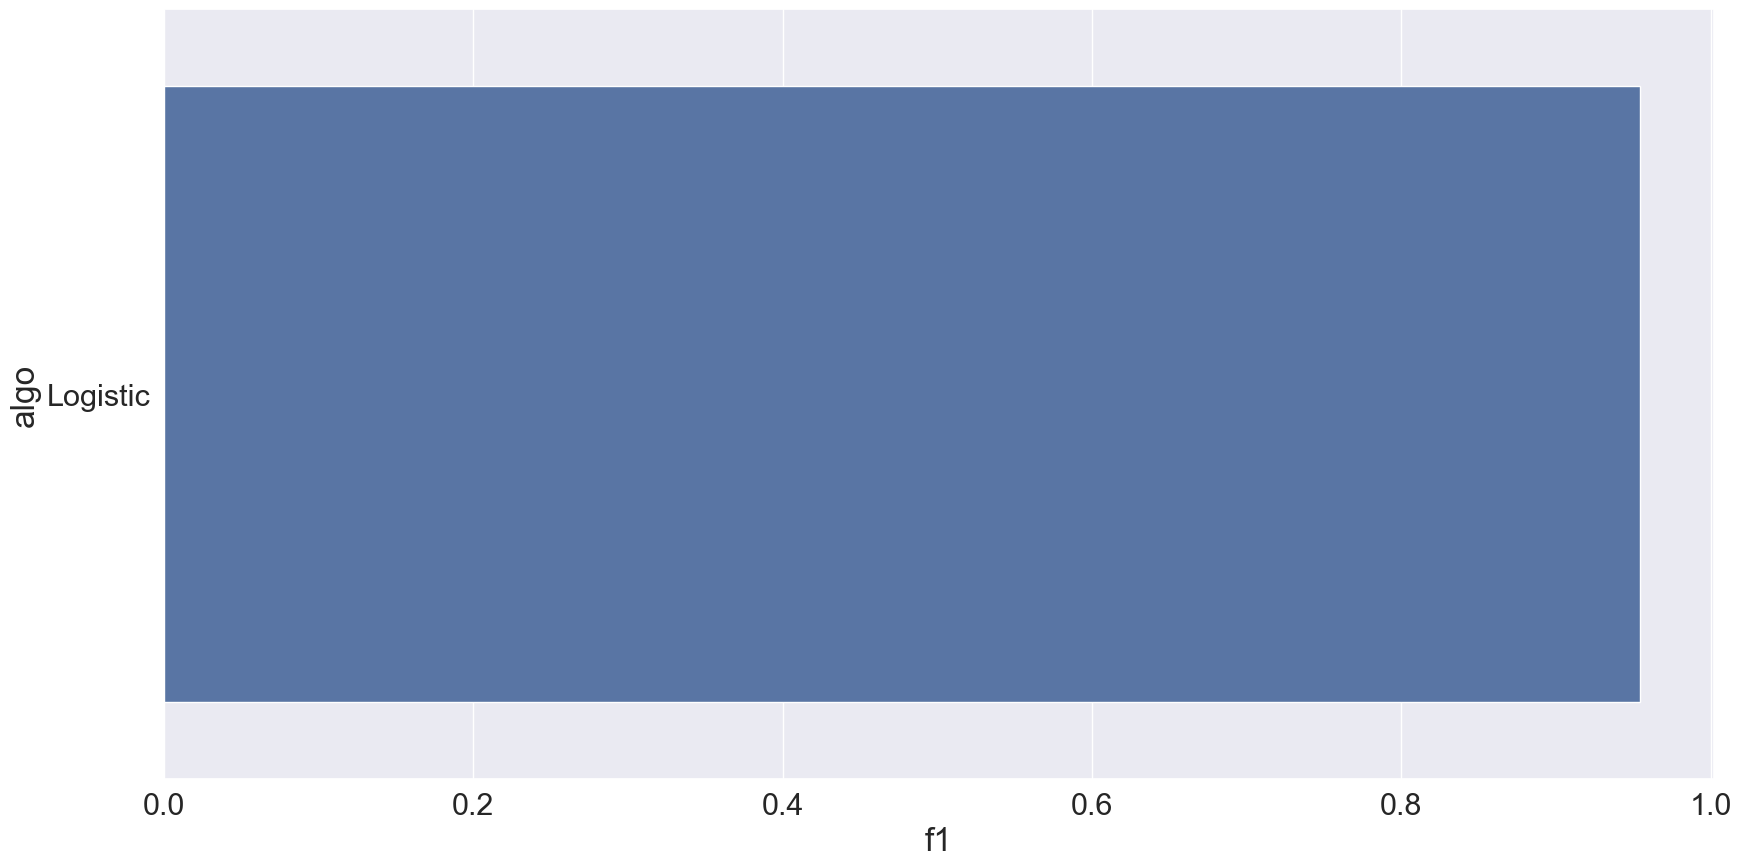

In [34]:
##### model
import lightgbm as lgbm
from sklearn.linear_model import LogisticRegression


##### sampling
from imblearn.over_sampling import SMOTE


##### pipeline
from imblearn.pipeline import Pipeline


##### dataset
X = review_df['reviews_for_vectorize']; y = review_df['label']


##### split train and test data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13, stratify=y)


##### cross-validation
skfold = StratifiedKFold(n_splits=5)


##### pipeline model
pipe_Logistic = Pipeline([
                ('vec', TfidfVectorizer(decode_error='ignore')),
                ('fit', LogisticRegression(solver='saga'))])


##### pipeline params -- vectorizer, smote
ks = [1,5,10]

grid_params_Logistic = [{
    "vec__min_df" : ks,
    "fit__C": [5],
    "fit__solver" : ["saga"],
    "fit__penalty" : ["l2"],
    "fit__max_iter": [1000]
}]

pipe = [pipe_Logistic]
params = [grid_params_Logistic]

jobs = 20

grid_dict = {
    0: 'Logistic',
            }

imblearn_model_object = {}; imblearn_model_acc = {}; imblearn_model_roc_auc = {}; imblearn_model_f1 = {}; imblearn_model_best_params = {}

#1. scoring = 'neg_mean_absolute_error' 로 설정.
# 일반적으로 scoring을 값이 클 수록 모델 성능이 좋은 것으로 사이킷런에서 인식하는데, 
# mae는 값이 클 수록 모델 성능이 저하되는 것이므로 Negative 키워드를 붙여서 사용

for idx , (param , model) in enumerate(zip(params , pipe)) :
    search = GridSearchCV(model, param, scoring  = "f1", cv=skfold,
                           n_jobs=jobs , verbose=True ) #  verbose가 있으면 함수 수행시 발생하는 상세한 정보 출력
    search.fit(X_train , y_train)
    y_pred = search.predict(X_test)
       
    imblearn_model_object[grid_dict.get(idx)] = search
    imblearn_model_acc[grid_dict.get(idx)] = accuracy_score(y_test, y_pred)  
    imblearn_model_roc_auc[grid_dict.get(idx)] = roc_auc_score(y_test, y_pred)
    imblearn_model_f1[grid_dict.get(idx)] = f1_score(y_test, y_pred)

    imblearn_model_best_params[grid_dict.get(idx)] = search.best_params_
    
print("finish")

fig ,ax = plt.subplots(figsize=(20, 10))
sns.set(font_scale = 2)
output = pd.DataFrame([model_f1.keys() , model_f1.values()], index = ["algo","f1"]).T # .T : 행 렬 변환
output.sort_values(["f1"], ascending= False ,inplace=True)
ax = sns.barplot(y="algo", x="f1", data=output)
plt.show()

In [35]:
imblearn_model_acc

{'Logistic': 0.9245033112582781}

In [36]:
imblearn_model_f1

{'Logistic': 0.9540939597315435}

In [37]:
imblearn_model_roc_auc

{'Logistic': 0.8443665884677121}

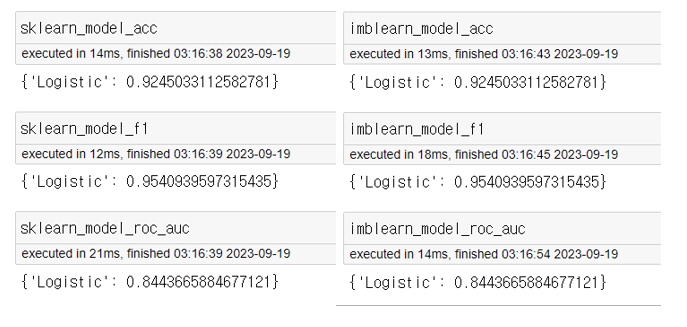

똑같다. 그냥 imblearn pipeline으로 통합하자